# Hourly Time Series Forecasting using Facebook's Prophet

In this notebook we will use facebook's prophet package to forecast hourly energy use. 

1. Import useful libraries

In [1]:
# !pip install pystan~=2.14
# !pip install prophet

In [2]:
# !pip install -q fsspec
# !pip install -q s3fs

In [3]:
import numpy as np
import pandas as pd

from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
#pio.renderers.default = "svg" # to be replaced by "iframe" if working on colab

c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data
The data we will be using is hourly power consumption data from PJM. Energy consumtion has some unique charachteristics. It will be interesting to see how prophet picks them up.

Pulling the `PJM East` which has data from 2002-2018 for the entire east region.

2. import the data thanks to the following link : ```https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Machine+Learning+Supervis%C3%A9/time_series/PJME_hourly.csv`` make sure to use the arguments ```index_col=[0], parse_dates=[0]``` and remove all dates previous to january the first 2008

In [4]:
pjme = pd.read_csv('https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Machine+Learning+Supervis%C3%A9/time_series/PJME_hourly.csv',
                   index_col=[0], parse_dates=[0]) # We set the index column and know it has dates

start_date = '01-Jan-2008'
pjme = pjme.loc[pjme.index >= start_date]
pjme = pjme[~pjme.index.duplicated()] # Remove duplicate indices
pjme.head()

PJME_MW
Datetime                    
2008-01-01 00:00:00  30998.0
2008-12-31 01:00:00  28937.0
2008-12-31 02:00:00  27714.0
2008-12-31 03:00:00  27120.0
2008-12-31 04:00:00  26995.0

3. Plot the time series

In [5]:
fig = px.line(x=pjme.index, y = pjme["PJME_MW"])
fig.show()

# EDA

4. Create this collection of new variables :
* ```date``` equal to the index
* ```hour``` equal to the hour of the day
* ```dayofweek```
* ```quarter```
* ```month```
* ```year```
* ```dayofyear```
* ```dayofmonth```
* ```weekofyear```

Create an object X containing the above variables and y containing the time series

In [7]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')

features_and_target = pd.concat([X, y], axis=1)

5. Create an object features_and_target containing both and display the first few lines

In [8]:
import datetime
features_and_target.head()

hour  dayofweek  quarter  month  year  dayofyear  \
Datetime                                                                
2008-01-01 00:00:00     0          1        1      1  2008          1   
2008-12-31 01:00:00     1          2        4     12  2008        366   
2008-12-31 02:00:00     2          2        4     12  2008        366   
2008-12-31 03:00:00     3          2        4     12  2008        366   
2008-12-31 04:00:00     4          2        4     12  2008        366   

                     dayofmonth  weekofyear  PJME_MW  
Datetime                                              
2008-01-01 00:00:00           1           1  30998.0  
2008-12-31 01:00:00          31           1  28937.0  
2008-12-31 02:00:00          31           1  27714.0  
2008-12-31 03:00:00          31           1  27120.0  
2008-12-31 04:00:00          31           1  26995.0

In [9]:
features_and_target.iloc[0,:]["year"]

2008.0

In [10]:
# See our features and target
features_and_target["date"] = features_and_target.apply(lambda x: datetime.date(int(x["year"]), 
                                            int(x["month"]),
                                            int(x["dayofmonth"])), axis=1)
features_and_target = features_and_target.groupby("date").mean("PJME_MW")

In [11]:
features_and_target

hour  dayofweek  quarter  month    year  dayofyear  dayofmonth  \
date                                                                         
2008-01-01  11.5        1.0      1.0    1.0  2008.0        1.0         1.0   
2008-01-02  11.5        2.0      1.0    1.0  2008.0        2.0         2.0   
2008-01-03  11.5        3.0      1.0    1.0  2008.0        3.0         3.0   
2008-01-04  11.5        4.0      1.0    1.0  2008.0        4.0         4.0   
2008-01-05  11.5        5.0      1.0    1.0  2008.0        5.0         5.0   
...          ...        ...      ...    ...     ...        ...         ...   
2018-07-30  11.5        0.0      3.0    7.0  2018.0      211.0        30.0   
2018-07-31  11.5        1.0      3.0    7.0  2018.0      212.0        31.0   
2018-08-01  11.5        2.0      3.0    8.0  2018.0      213.0         1.0   
2018-08-02  11.5        3.0      3.0    8.0  2018.0      214.0         2.0   
2018-08-03   0.0        4.0      3.0    8.0  2018.0      215.0         3.0   

            weekofyear       PJME_MW  
date                                  
2008-01-01         1.0  30635.125000  
2008-01-02         1.0  36735.000000  
2008-01-03         1.0  39986.416667  
2008-01-04         1.0  38549.125000  
2008-01-05         1.0  33803.416667  
...                ...           ...  
2018-07-30        31.0  32957.416667  
2018-07-31        31.0  34539.083333  
2018-08-01        31.0  39230.791667  
2018-08-02        31.0  39593.041667  
2018-08-03        31.0  35486.000000  

[3868 rows x 9 columns]

## Plotting the Features to see trends

6. Plot the time series against hour, dayofweek, weekofyear, year


In [12]:
fig = px.scatter(features_and_target, x = 'hour', y = 'PJME_MW')
fig.show()
fig = px.scatter(features_and_target, x = 'dayofweek', y = 'PJME_MW', color = 'hour')
fig.show()
fig = px.scatter(features_and_target, x = 'weekofyear', y = 'PJME_MW', color = 'hour')
fig.show()
fig = px.scatter(features_and_target, x = 'year', y = 'PJME_MW', color = 'hour')
fig.show()

# Train/Test Split
7. Cut off the data after 2015 to use as our validation set. We will train on earlier data.

In [13]:
split_date = datetime.datetime.strptime('2012-01-01',"%Y-%m-%d").date()
pjme_train = features_and_target.loc[features_and_target.index <= split_date].copy()
pjme_test = features_and_target.loc[features_and_target.index > split_date].copy()

8. plot the series with different colors for the train and test set to visualize the separation.

In [14]:
fig = px.line(x = pjme_train.index, y = pjme_train["PJME_MW"])
fig.add_trace(px.line(x = pjme_test.index, y = pjme_test["PJME_MW"]).data[0])
fig['data'][1]['line']['color']="#4BE8E0"
fig.show()

# Simple Prophet Model
9. In pjme_train rename the Datetime variable "ds" and PJME_MW "y" to fit into the Prophet framework

In [15]:
# Format data for prophet model using ds and y
pjme_train_prophet = pjme_train.reset_index().rename(columns={'date':'ds','PJME_MW':'y'})
pjme_train_prophet.head()

ds  hour  dayofweek  quarter  month    year  dayofyear  dayofmonth  \
0  2008-01-01  11.5        1.0      1.0    1.0  2008.0        1.0         1.0   
1  2008-01-02  11.5        2.0      1.0    1.0  2008.0        2.0         2.0   
2  2008-01-03  11.5        3.0      1.0    1.0  2008.0        3.0         3.0   
3  2008-01-04  11.5        4.0      1.0    1.0  2008.0        4.0         4.0   
4  2008-01-05  11.5        5.0      1.0    1.0  2008.0        5.0         5.0   

   weekofyear             y  
0         1.0  30635.125000  
1         1.0  36735.000000  
2         1.0  39986.416667  
3         1.0  38549.125000  
4         1.0  33803.416667

10. Create an instance of the Prophet model and fit it on the train data.

In [16]:
# Setup and train model and fit
model = Prophet()
model.fit(pjme_train_prophet)

16:40:57 - cmdstanpy - INFO - Chain [1] start processing
16:40:57 - cmdstanpy - INFO - Chain [1] done processing


11. Make predictions with your trained default prophet model on the test set

In [17]:
# Predict on training set with model
pjme_test_prophet = pjme_test.reset_index().rename(columns={'date':'ds'})
pjme_test_fcst = model.predict(df=pjme_test_prophet)

In [18]:
pjme_test_fcst.head()

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2012-01-02  31611.541293  30067.732282  36829.565556  31611.541293   
1 2012-01-03  31607.430898  30387.431291  37260.438204  31607.430898   
2 2012-01-04  31603.320504  30626.142683  37356.395080  31603.320504   
3 2012-01-05  31599.210109  30768.925126  37339.026919  31599.210109   
4 2012-01-06  31595.099714  30584.031614  36866.743383  31595.099714   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  31611.541293     1795.125054           1795.125054           1795.125054   
1  31607.430898     2313.223868           2313.223868           2313.223868   
2  31603.320504     2381.920274           2381.920274           2381.920274   
3  31599.210109     2381.734476           2381.734476           2381.734476   
4  31595.099714     1978.539754           1978.539754           1978.539754   

        weekly  weekly_lower  weekly_upper       yearly  yearly_lower  \
0   699.550562    699.550562    699.550562  1095.574493   1095.574493   
1  1136.471405   1136.471405   1136.471405  1176.752463   1176.752463   
2  1103.528792   1103.528792   1103.528792  1278.391483   1278.391483   
3   983.084397    983.084397    983.084397  1398.650080   1398.650080   
4   443.373256    443.373256    443.373256  1535.166498   1535.166498   

   yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0   1095.574493                   0.0                         0.0   
1   1176.752463                   0.0                         0.0   
2   1278.391483                   0.0                         0.0   
3   1398.650080                   0.0                         0.0   
4   1535.166498                   0.0                         0.0   

   multiplicative_terms_upper          yhat  
0                         0.0  33406.666347  
1                         0.0  33920.654766  
2                         0.0  33985.240778  
3                         0.0  33980.944585  
4                         0.0  33573.639468

13. Plot the trend, the yearly seasonnality, the weekly seasonnality, and the daily seasonnality.

c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\prophet\plot.py:226: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\prophet\plot.py:349: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\prophet\plot.py:352: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



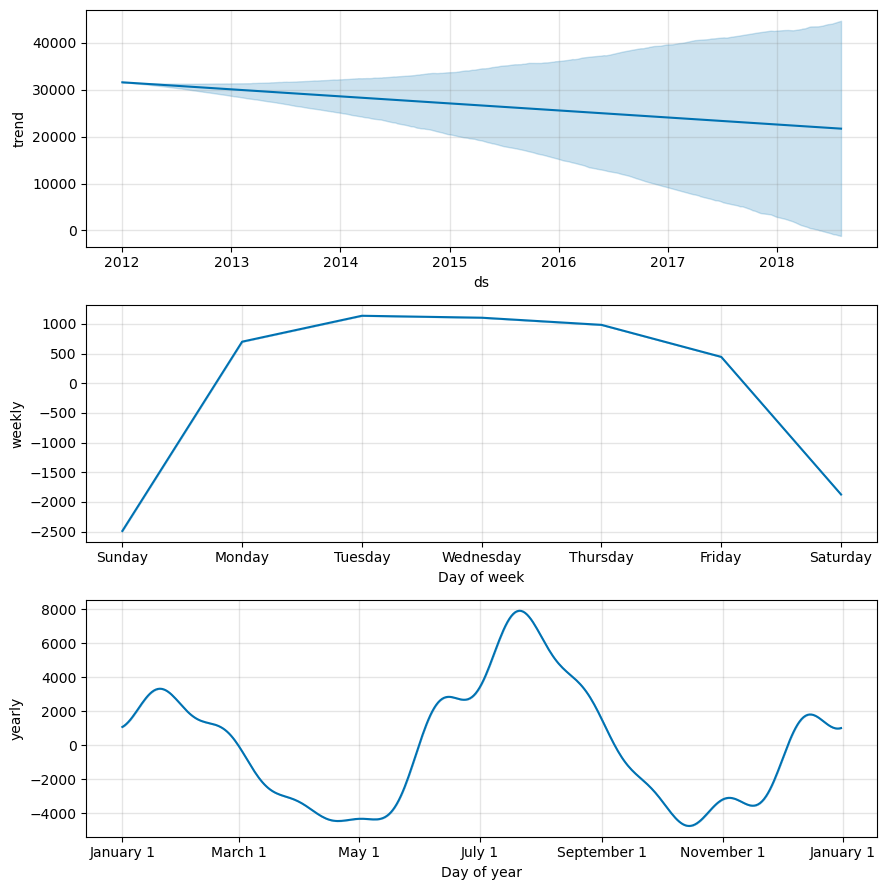

In [19]:
# Plot the components of the model
fig = model.plot_components(pjme_test_fcst)

# Compare Forecast to Actuals

14. Plot the forcasts against the actual values in the test set.

In [20]:
fig = px.scatter(x = pjme_test.index, y = pjme_test['PJME_MW'])
fig.add_trace(px.line(pjme_test_fcst, x="ds", y="yhat").data[0])
fig['data'][1]['line']['color']="#4BE8E0"
fig.show()

# Look at first month of predictions

15. Compare in a graph predictions for the first month against reality.

In [21]:
mask = (pjme_test_prophet.ds >= datetime.datetime.strptime('01-01-2015',"%m-%d-%Y").date()) & (pjme_test_prophet.ds < datetime.datetime.strptime('02-01-2015',"%m-%d-%Y").date())
maskfcst = (pjme_test_fcst.ds >= datetime.datetime.strptime('01-01-2015',"%m-%d-%Y")) & (pjme_test_fcst.ds < datetime.datetime.strptime('02-01-2015',"%m-%d-%Y"))
fig = px.scatter(x = pjme_test_prophet.loc[mask,:].ds, y = pjme_test_prophet.loc[mask,'PJME_MW'], width = 1200)
fig.add_trace(px.line(pjme_test_fcst.loc[maskfcst,:], x="ds", y="yhat").data[0])
fig['data'][1]['line']['color']="#4BE8E0"
fig.show()

# Single Week of Predictions

16. plot the first week of data against the model's predictions

In [22]:

mask = (pjme_test_prophet.ds >= datetime.datetime.strptime('01-01-2015',"%m-%d-%Y").date()) & (pjme_test_prophet.ds < datetime.datetime.strptime('01-08-2015',"%m-%d-%Y").date())
maskfcst = (pjme_test_fcst.ds >= datetime.datetime.strptime('01-01-2015',"%m-%d-%Y")) & (pjme_test_fcst.ds < datetime.datetime.strptime('01-08-2015',"%m-%d-%Y"))

fig = px.scatter(x = pjme_test_prophet.loc[mask,:].ds, y = pjme_test_prophet.loc[mask,'PJME_MW'], width = 1200)
fig.add_trace(px.line(pjme_test_fcst.loc[maskfcst,:], x="ds", y="yhat").data[0])
fig['data'][1]['line']['color']="#4BE8E0"
fig.show()

17. Calculate the MSE, the MAE and the MAPE (mean obsolute percentage error) for this model over the test dataset
$$MAPE = \frac{1}{n}\sum_{t=1}^{n}|\frac{Y_t - \hat{Y_t}}{Y_t}|$$

In [23]:
mse = mean_squared_error(y_true=pjme_test_prophet['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

print("The MSE on the test set is : \n {}".format(mse))

The MSE on the test set is : 
 38885234.84924373


In [24]:
mae = mean_absolute_error(y_true=pjme_test_prophet['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

print("The MAE on the test set is : \n {}".format(mae))

The MAE on the test set is : 
 5129.331337822515


In [25]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_true=pjme_test_prophet['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

print("The MAPE on the test set is : \n {}".format(mape))

The MAPE on the test set is : 
 15.985307679244745


# Adding Holidays
Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a *Holiday Effects* parameter that can be provided to the model prior to training. 

We will use the built in pandas `USFederalHolidayCalendar` to pull the list of holidays

18. Create a test_holidays object containing the us federal holidays for the considered test period and an object train_holidays for the considered train period.

In [26]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
train_holidays = cal.holidays(start=pjme_train_prophet.ds.min(),
                              end=pjme_train_prophet.ds.max())
test_holidays = cal.holidays(start=pjme_test_prophet.ds.min(),
                             end=pjme_test_prophet.ds.max())

19. Create a DataFrame contaning all holidays over the observed period with a ds column with the dates and a holiday column with the holidays and convert ds column to datetime format.

In [28]:
features_and_target.head()

date  hour  dayofweek  quarter  month    year  dayofyear  dayofmonth  \
0  2008-01-01  11.5        1.0      1.0    1.0  2008.0        1.0         1.0   
1  2008-01-02  11.5        2.0      1.0    1.0  2008.0        2.0         2.0   
2  2008-01-03  11.5        3.0      1.0    1.0  2008.0        3.0         3.0   
3  2008-01-04  11.5        4.0      1.0    1.0  2008.0        4.0         4.0   
4  2008-01-05  11.5        5.0      1.0    1.0  2008.0        5.0         5.0   

   weekofyear       PJME_MW  is_holiday  
0         1.0  30635.125000        True  
1         1.0  36735.000000       False  
2         1.0  39986.416667       False  
3         1.0  38549.125000       False  
4         1.0  33803.416667       False

In [29]:
# Create a dataframe with holiday, ds columns
features_and_target = features_and_target.reset_index()
features_and_target['is_holiday'] = features_and_target.date.isin([d.date() for d in cal.holidays()])
holiday_df = features_and_target.loc[features_and_target['is_holiday']].reset_index().rename(columns={'date':'ds'})
holiday_df['holiday'] = 'USFederalHoliday'
# holiday_df = holiday_df.drop(['PJME_MW','date','is_holiday'], axis=1)
holiday_df = holiday_df.drop(['PJME_MW','is_holiday'], axis=1)
holiday_df.head()

level_0  index          ds  hour  dayofweek  quarter  month    year  \
0        0      0  2008-01-01  11.5        1.0      1.0    1.0  2008.0   
1       20     20  2008-01-21  11.5        0.0      1.0    1.0  2008.0   
2       48     48  2008-02-18  11.5        0.0      1.0    2.0  2008.0   
3      146    146  2008-05-26  11.5        0.0      2.0    5.0  2008.0   
4      185    185  2008-07-04  11.5        4.0      3.0    7.0  2008.0   

   dayofyear  dayofmonth  weekofyear           holiday  
0        1.0         1.0         1.0  USFederalHoliday  
1       21.0        21.0         4.0  USFederalHoliday  
2       49.0        18.0         8.0  USFederalHoliday  
3      147.0        26.0        22.0  USFederalHoliday  
4      186.0         4.0        27.0  USFederalHoliday

In [30]:
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])

20. Create an instance of the Prophet model with ```holidays = holiday_df``` the DataFrame we have just created, and train that model on the training set.

In [31]:
# Setup and train model with holidays
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train_prophet)

16:51:56 - cmdstanpy - INFO - Chain [1] start processing
16:51:56 - cmdstanpy - INFO - Chain [1] done processing


## Predict With Holidays

21. Make predictions for the test set with the holiday model

In [32]:
# Predict on training set with model
pjme_test_fcst_with_hols = model_with_holidays.predict(df=pjme_test_prophet)

## Plot Holiday Effect

22. Plot the different components of the holiday model

c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\prophet\plot.py:226: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\prophet\plot.py:349: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\prophet\plot.py:352: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



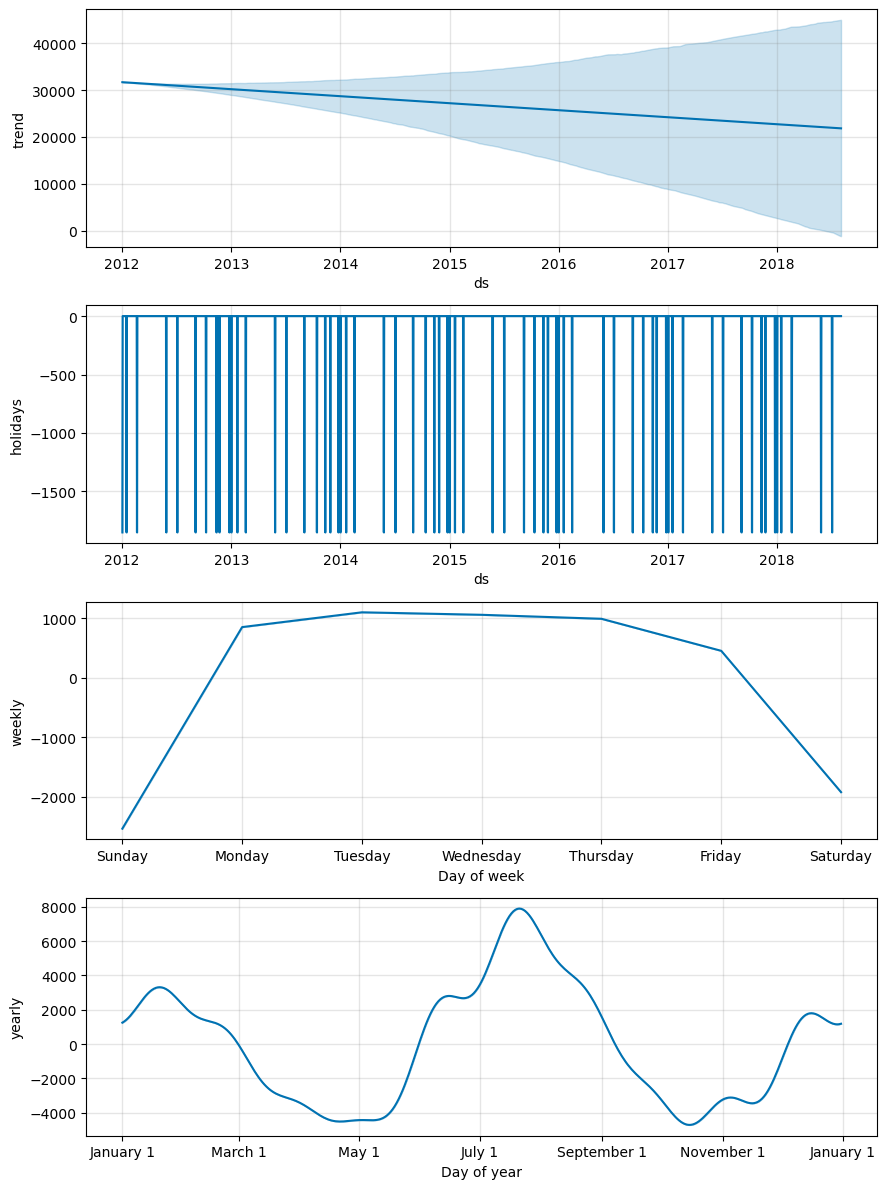

In [33]:
fig2 = model_with_holidays.plot_components(pjme_test_fcst_with_hols)

# Error Metrics with Holidays Added
23. Calculate the MSE, MAE and MAPE for the holiday model on the test set.

In [34]:
mse = mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

print("The MSE on the test set is : \n {}".format(mse))

The MSE on the test set is : 
 38417020.246576816


In [35]:
mae = mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

print("The MAE on the test set is : \n {}".format(mae))

The MAE on the test set is : 
 5093.445674137663


In [36]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

print("The MAPE on the test set is : \n {}".format(mape))

The MAPE on the test set is : 
 15.872271663657994
